# Predicting the Quality of Vinho Verde Wine Based on Physical Properties
## DSCI 100 Project Final Report
Date: November/December 2022

Group: 157

## Proposal Overview
- Introduction
- Methods & Results
- Discussion
- References

***
### *For our purposes only - remove this cell before handing in project!!*

To do

[X] Introduction

[] Methods & Results

[] Add titles and legends to all figures and tables

[] Discussion

[] References

[] Check for typos/proofread

***

## Introduction

There are many factors that give white wine its distinctive taste. Sweetness is determined by **residual sugars** left over from fermentation, and is measured in grams per decimeter cubed. The sugars that were consumed during fermentation determine the **alcohol content** of the wine – grapes with more sugar create more alcoholic wines. The tart or sour taste of the wine comes from its **acidity**. All wine has a **pH** between 3 and 4, but small variations in acidity can create a big difference in taste. Other properties such as **citric acid**, **sulfur dioxide**, **chlorides**, and **sulfates** also affect the quality of the wine.

In our project, we ask, what physical properties lead to a higher quality white wine? To solve this problem, we will be using data from approximately 5,000 variants of the Portuguese wine “Vinho Verde” collected by Cortez et al. (2009). 

Though all variables provided affect the quality of a wine, we chose a subset of the variables based on which appeared to have an obvious relationship with quality (summarized in the following section) in addition to what was of interest to us. The variables we will be using in our analysis of white wine quality are:
- Fixed acidity (g/dm^3)
- Citric acid (g/dm^3)
- Residual sugar (g/dm^3)
- pH (logarithmic units, from 1-12)
- Alcohol (volume percent, from 0 to 100)
- Quality (a score, from 3-9, with 9 being the best quality)

## Methods & Results

"Describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis."

#### Importing relevant libraries

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Importing data from the web

In [2]:
data <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
wine <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", delim = ";")

Rows: 4898 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Tidying the data

In [3]:
wine <- wine |>
    filter(quality > 3 & quality < 9) |>
    mutate(quality = as.factor(quality))

colnames(wine) <- make.names(colnames(wine))
"Table 1. Preview of the tidied data"
head(wine)

[1] "Table 1. Preview of the tidied data"

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6


#### Splitting the data

In [4]:
wine_split <- initial_split(wine, prop = 0.75, strata = quality)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)

#### Summarizing the data in tables

In [11]:
#Variables available to us
#colnames(wine)

# Get the number of observations and their respective percentage of each quality in the training set
wine_prop <- group_by(wine_training, quality) |> 
    summarize(n = n()) |>
    mutate(percent = round(100 * n / sum(n), digits = 1))

"Table 2. Proportion of wines of each quality in the dataset"
wine_prop

[1] "Table 2. Proportion of wines of each quality in the dataset"

quality,n,percent
<fct>,<int>,<dbl>
4,121,3.3
5,1087,29.8
6,1648,45.1
7,659,18.0
8,138,3.8


**Table 2** shows the number of observations for each quality of wine and their proportion of the dataset for the training data.

In [12]:
"Table 3. Average value of each variable for each quality of wine"
quality_averages <- wine_training |>
    group_by(quality) |>
    summarise(across(everything(), mean))

quality_averages

[1] "Table 3. Average value of each variable for each quality of wine"

quality,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,7.141322,0.3988430,0.2919835,4.655372,0.05219835,23.78099,126.3760,0.9943922,3.186364,0.4734711,10.076446
5,6.924885,0.3008786,0.3405244,7.360212,0.05116835,36.59614,150.7999,0.9952920,3.171352,0.4826127,9.797084
6,6.846481,0.2604217,0.3401517,6.352731,0.04579369,35.74697,137.9533,0.9939200,3.188089,0.4927488,10.584011
7,6.736950,0.2612291,0.3283915,5.191502,0.03843703,34.59939,126.4841,0.9924850,3.215387,0.5015326,11.337562
8,6.622464,0.2707609,0.3318116,5.525362,0.03850725,37.14493,126.5797,0.9921825,3.222174,0.4873913,11.620290


**Table 3** shows the average value for each variable for each quality of wine. This allowed us to gain a broad overview of how variables change as wine quality changes. We selected variables for our analysis based on how much they changed with quality as well as what elements we found interesting.

#### Visualizing the data

Warning message:
“Removed 63 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 22 rows containing missing values (geom_bar).”


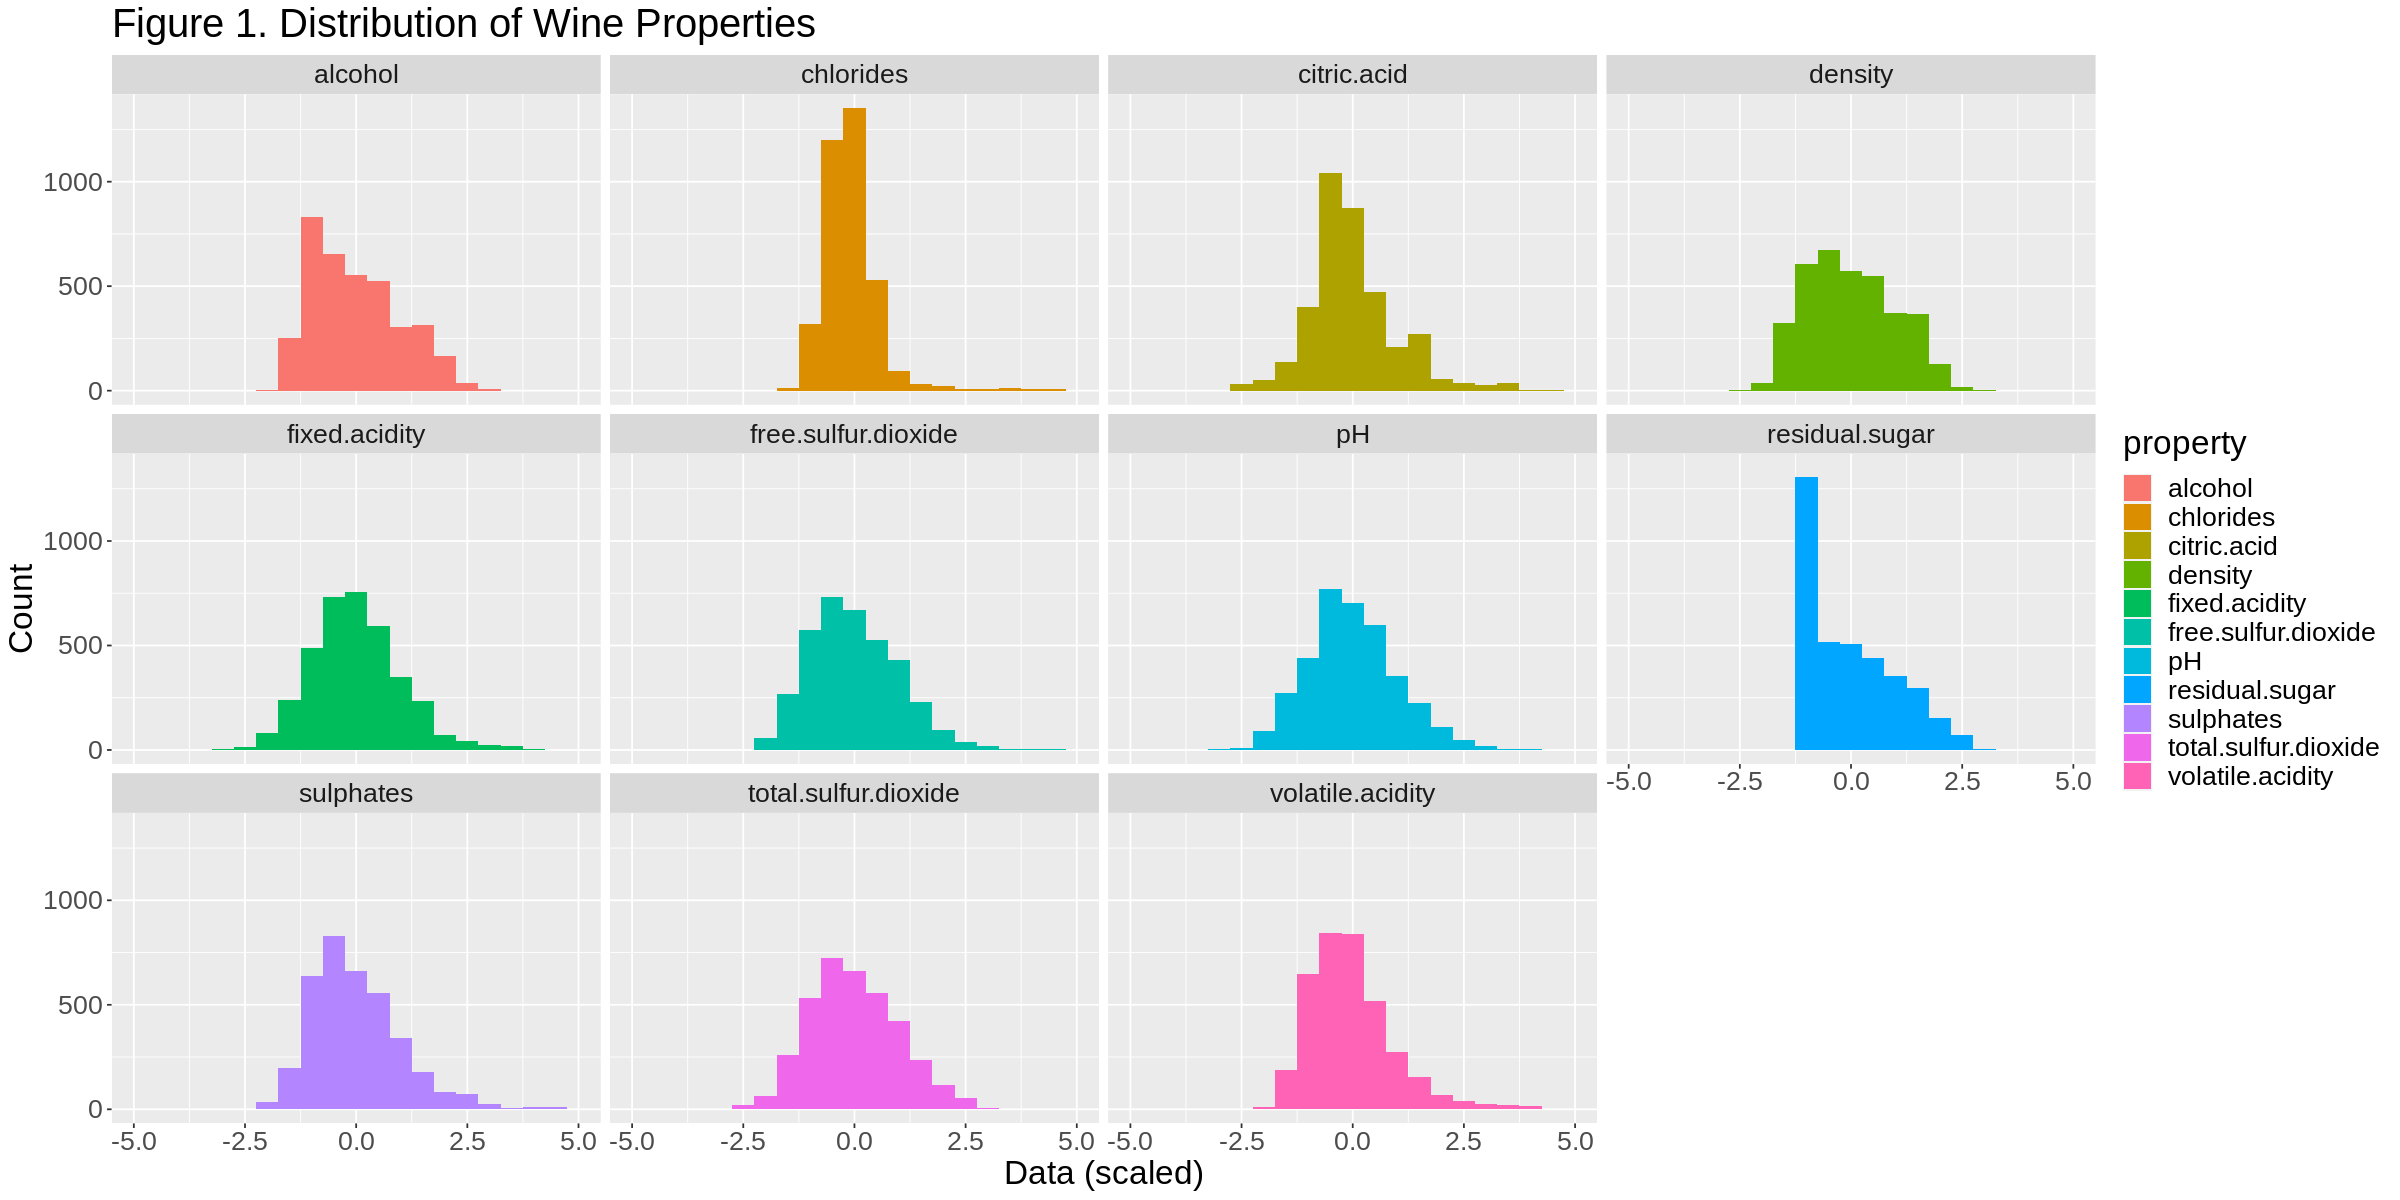

In [7]:
wine_scaled <- select(wine_training, fixed.acidity:alcohol) |>
    scale() |>
    as.data.frame() |>
    pivot_longer(fixed.acidity:alcohol , names_to = "property", values_to = "value")

options(repr.plot.width = 20, repr.plot.height = 10)

frequency_dist <- ggplot(wine_scaled, aes(x=value,fill=property)) +
    geom_histogram(binwidth = 0.5) +
    facet_wrap(~ property) + 
    xlab("Data (scaled)") + 
    ylab("Count") +
    ggtitle("Figure 1. Distribution of Wine Properties") + 
    xlim(-5, 5) +
    theme(text = element_text(size = 20))

frequency_dist

**Figure 1** shows the distribution of the eleven different properties contained within our dataset. Most of these properties have a normal distribution, although some do not. Alcohol and residual sugars are noticably left skewed, while citric acid has an unusually high count at x=3.

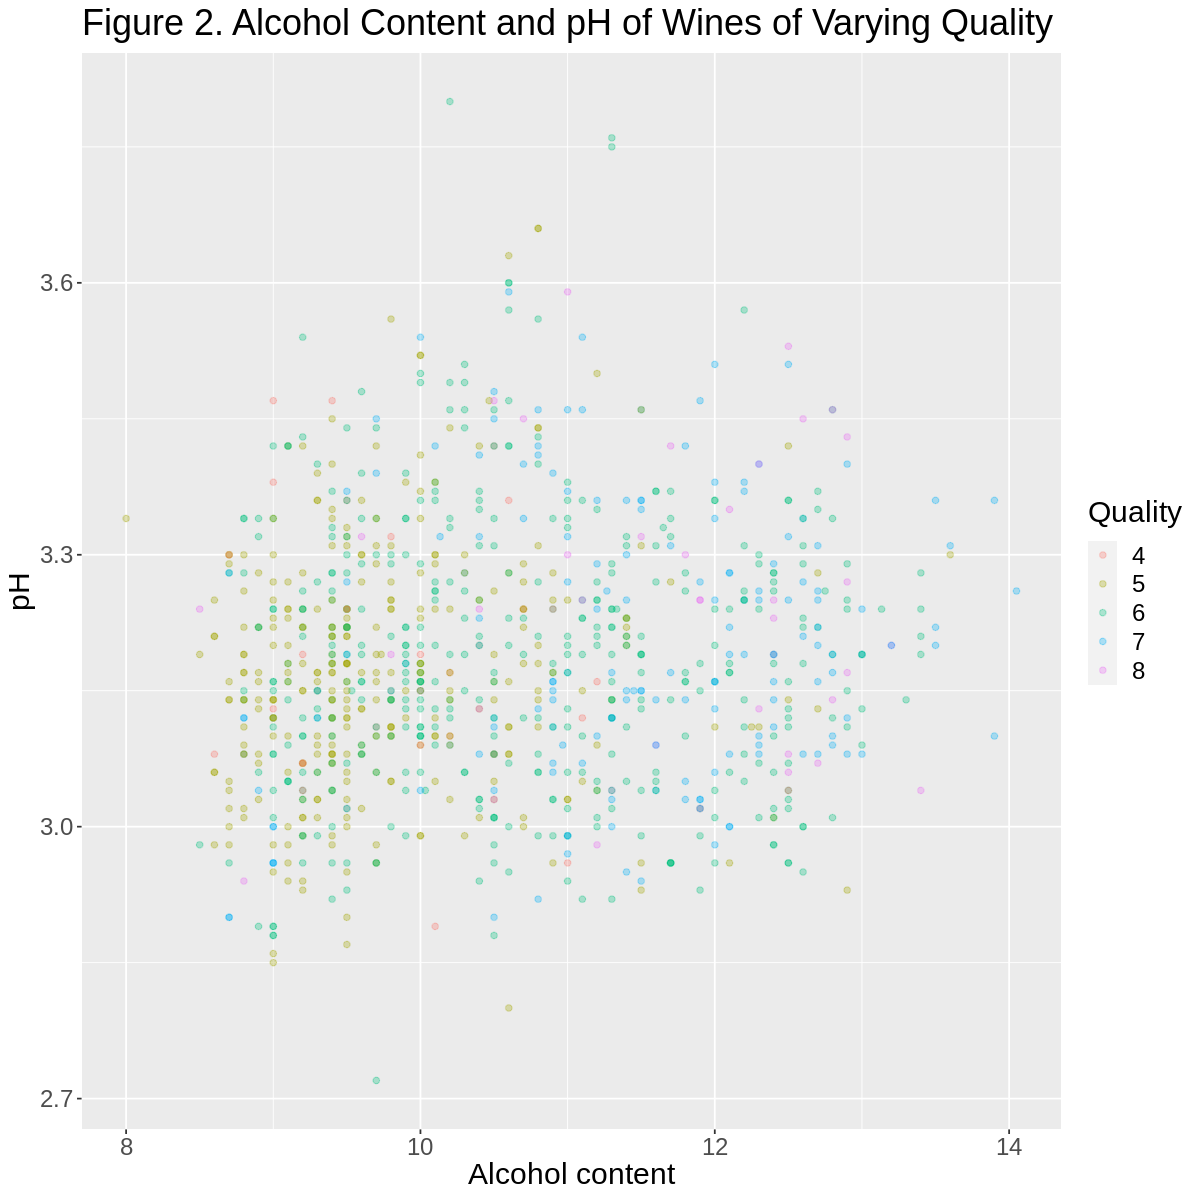

In [8]:
# Alcohol content, pH, and rating

small_training <- rep_sample_n(wine_training, size = 1000)

options(repr.plot.width = 10, repr.plot.height = 10)

alcohol_ph_plot <- ggplot(small_training, aes(x = alcohol, y = pH, colour = quality)) +
    geom_point(alpha = 0.3) +
    labs(x = "Alcohol content", y = "pH", colour = "Quality") +
    theme(text = element_text(size = 18)) +
    ggtitle("Figure 2. Alcohol Content and pH of Wines of Varying Quality")

alcohol_ph_plot

**Figure 2** shows how wine quality changes as the variables pH and alcohol content change for a subset of the training data. Wines with higher alcohol content receive higher ratings. pH does not have as drastic of an effect, though some wines with higher pH have lower quality scores.

Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


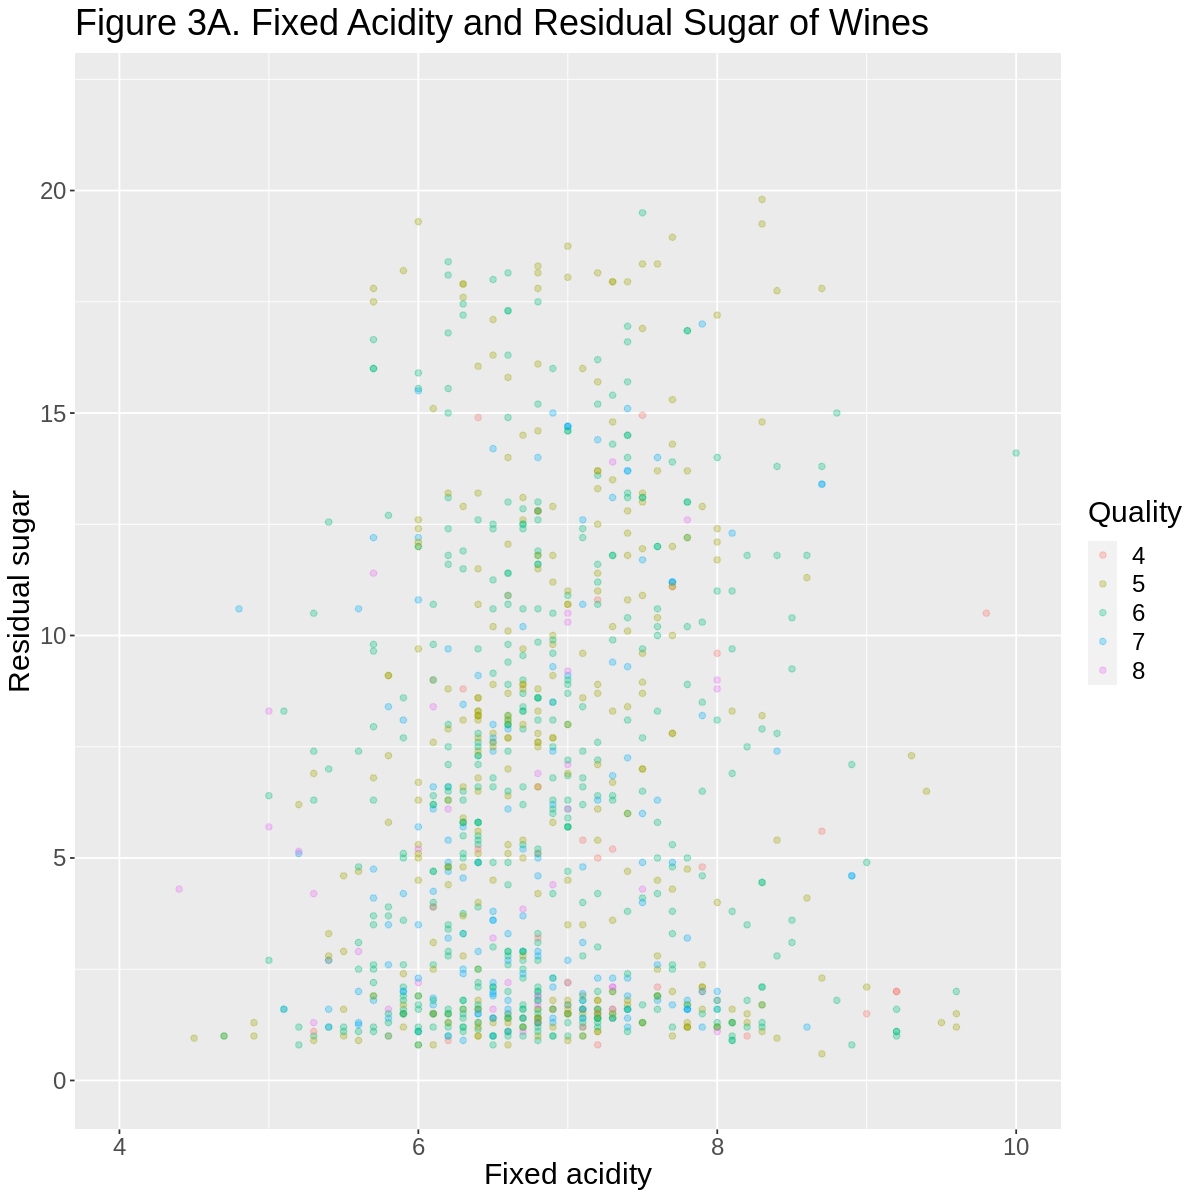

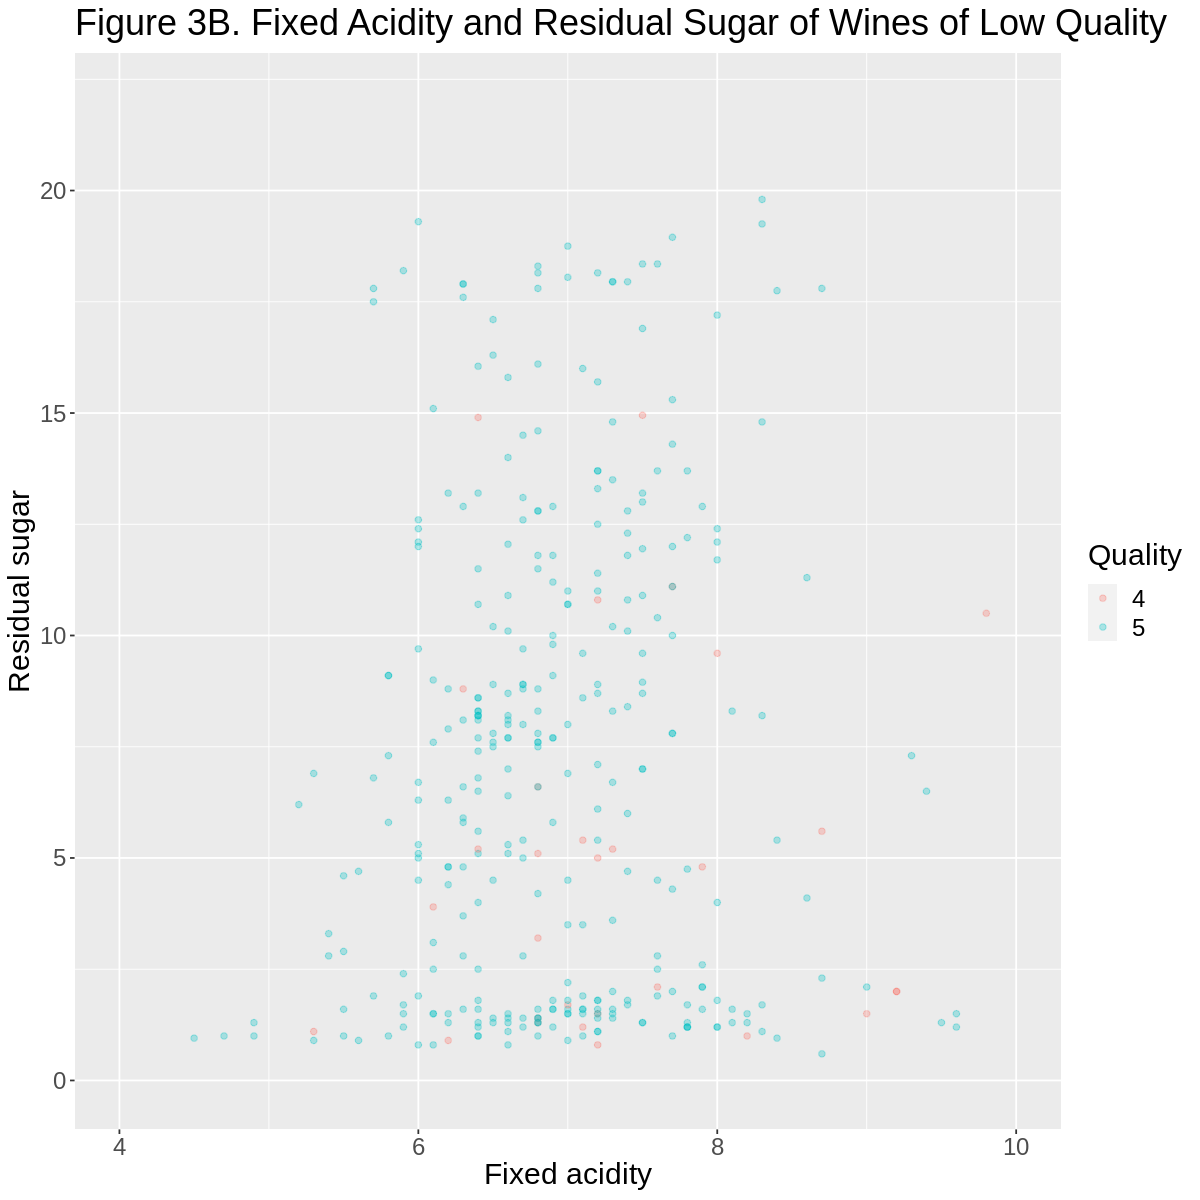

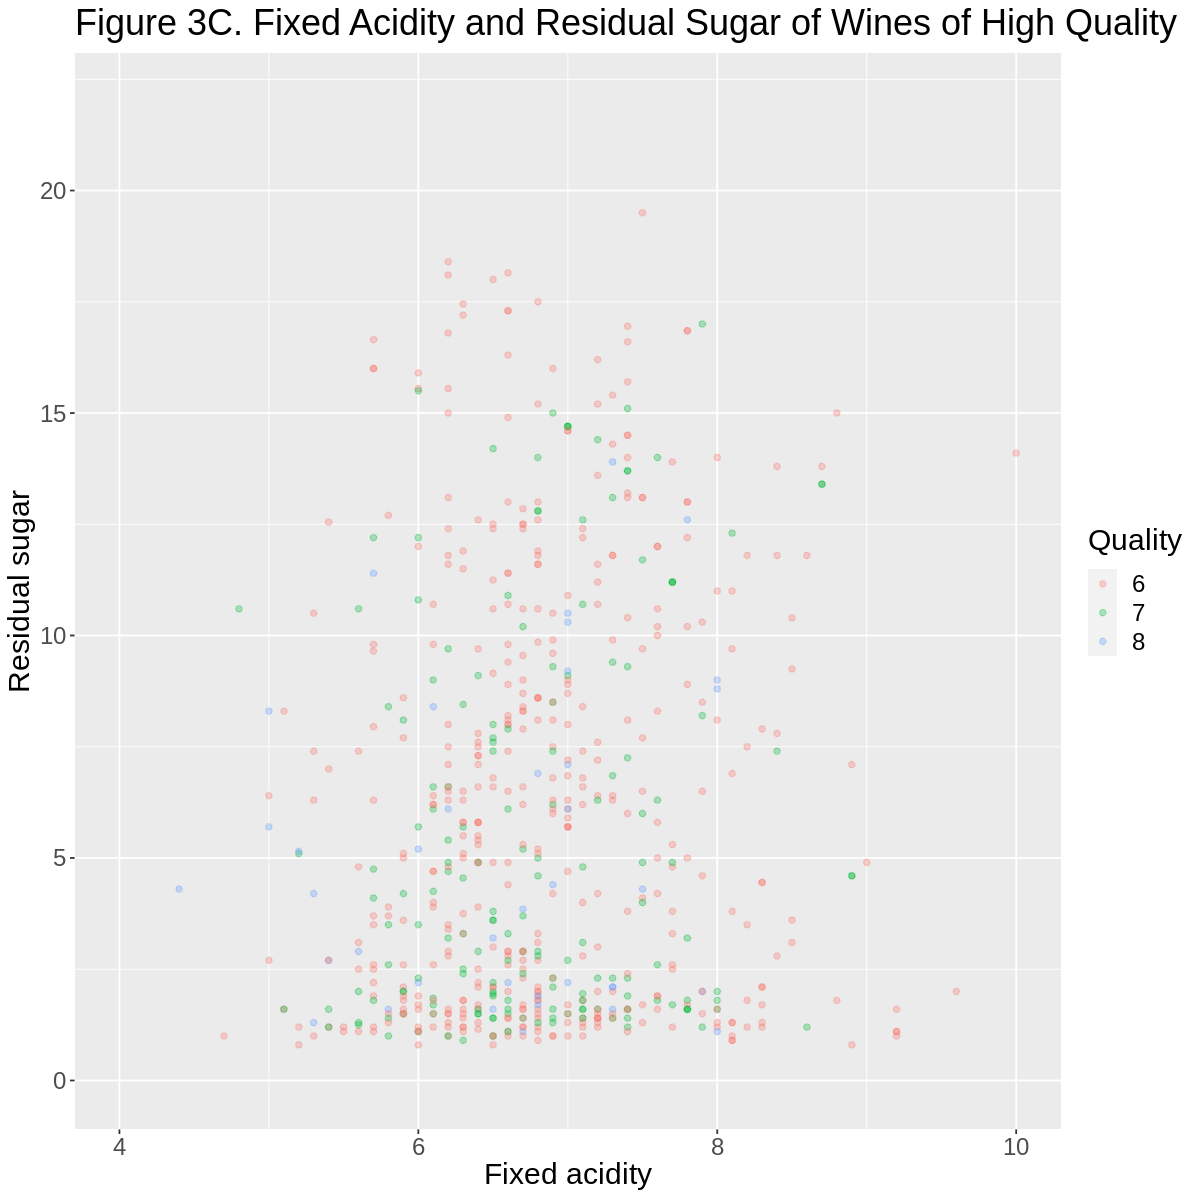

In [9]:
sugar_plot <- function(title, qualities = list("4", "5", "6", "7", "8")) {
    sugar_data <- filter(small_training, quality %in% qualities)
    return (ggplot(sugar_data, aes(x = fixed.acidity, y = residual.sugar, colour = quality)) +
        geom_point(alpha = 0.3) +
        labs(x = "Fixed acidity", y = "Residual sugar", colour = "Quality") +
        theme(text = element_text(size = 18)) +
        ggtitle(title) +
        xlim(4, 10) +
        ylim(0, 22))
}

sugar_plot("Figure 3A. Fixed Acidity and Residual Sugar of Wines")
sugar_plot("Figure 3B. Fixed Acidity and Residual Sugar of Wines of Low Quality", list("4", "5"))
sugar_plot("Figure 3C. Fixed Acidity and Residual Sugar of Wines of High Quality", list("6", "7", "8"))

**Figure 3A** shows how wine quality changes for a subset of the training data as the variables fixed acidity and residual sugar change. Many wines with higher fixed acidity have lower quality scores. The trends for residual sugars are hard to determine. **Figure 3B and 3C** split this data into low (≤ 5) and high (≥ 6) quality wines to better see possible trends. Higher quality wines appear to have a more balanced (in the middle) residual sugar profile.

#### Designing the model

In [13]:
set.seed(1234)

wine_vfold <- vfold_cv(wine_training, v = 10, strata = quality)

wine_recipe <- recipe(quality ~ fixed.acidity + citric.acid + residual.sugar + pH + alcohol, data = wine_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

grid_vals <- tibble(neighbors = seq(from=1, to=10, by=1))

knn_results <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = wine_vfold, grid = grid_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

"Table 4. Model accuracy for each value of K"
knn_results

[1] "Table 4. Model accuracy for each value of K"

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5992474,10,0.009789984,Preprocessor1_Model01
2,accuracy,multiclass,0.5989735,10,0.009757347,Preprocessor1_Model02
3,accuracy,multiclass,0.5384558,10,0.007680251,Preprocessor1_Model03
4,accuracy,multiclass,0.5277828,10,0.008276039,Preprocessor1_Model04
5,accuracy,multiclass,0.5206572,10,0.006578653,Preprocessor1_Model05
6,accuracy,multiclass,0.5173695,10,0.006363289,Preprocessor1_Model06
7,accuracy,multiclass,0.5105315,10,0.006266516,Preprocessor1_Model07
8,accuracy,multiclass,0.5102583,10,0.008918736,Preprocessor1_Model08
9,accuracy,multiclass,0.5028646,10,0.008653256,Preprocessor1_Model09


**Table 4** shows the accuracy and other metrics for the model with different values of K (1 to 10). The accuracy is an average over 10 folds through cross validation. Two neighbours gives the greatest accuracy with a value of 59.90% (S.D. 0.98).

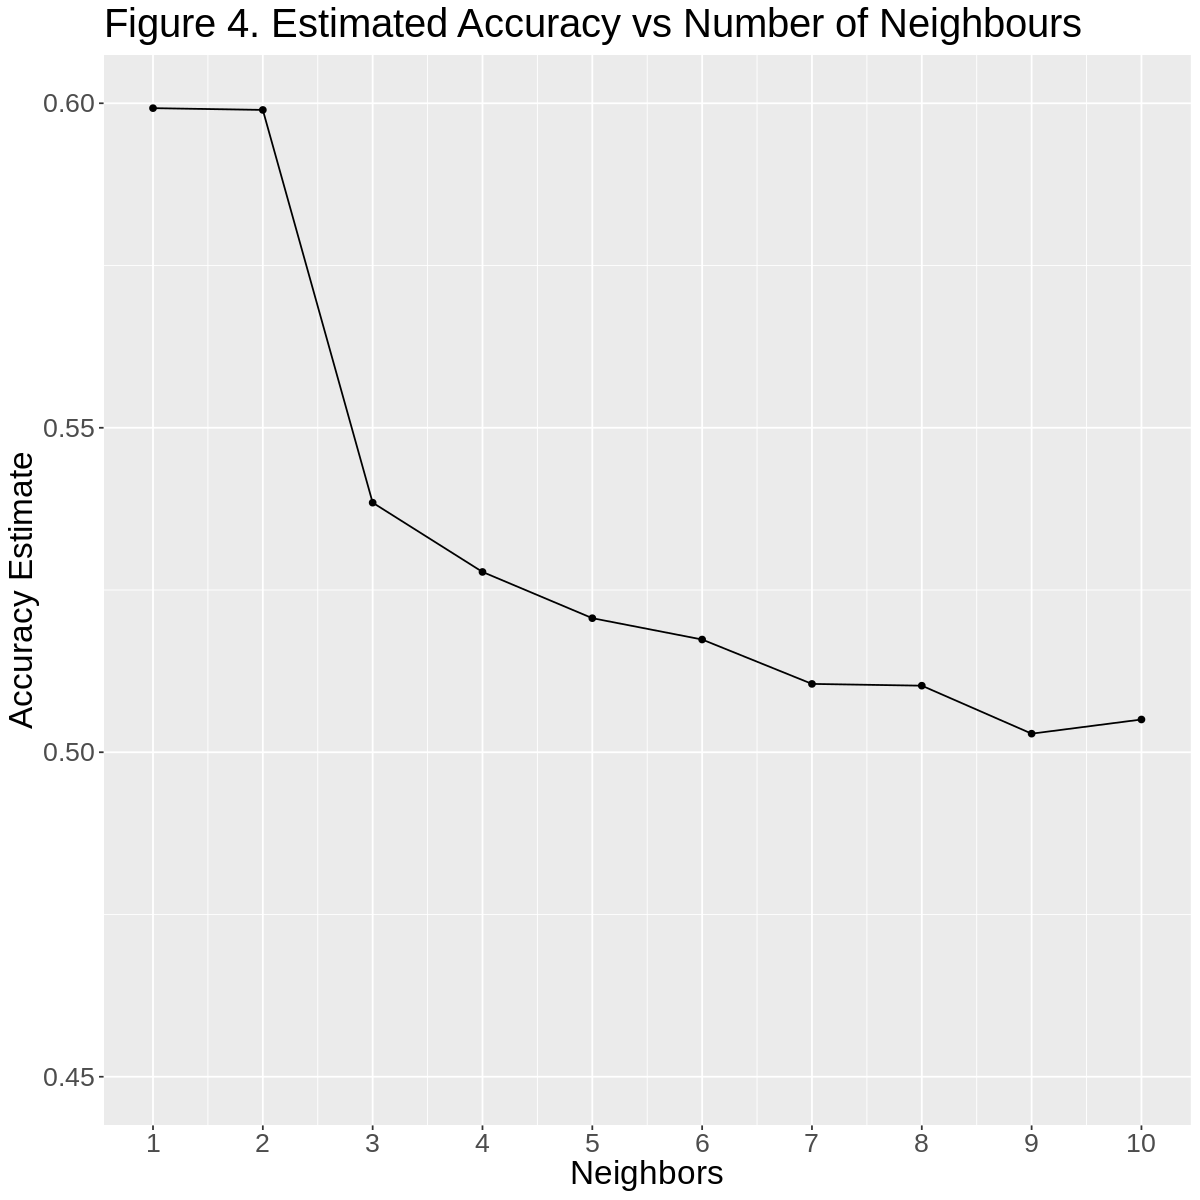

In [15]:
cross_val_plot <- ggplot(knn_results, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 10, by = 1)) +
    scale_y_continuous(limits = c(0.45, 0.6)) +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure 4. Estimated Accuracy vs Number of Neighbours")

cross_val_plot

**Figure 4** shows the accuracy (as an average over 10 folds) of our model for the training data for different values of K.

#### Building the model with best K

In [16]:
set.seed(2234)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
       set_engine("kknn") |>
       set_mode("classification")

wine_fit <- workflow() |>
       add_recipe(wine_recipe) |>
       add_model(knn_spec) |>
       fit(data = wine_training)

#### Predicting with the model

In [17]:
"Table 3. Predictions vs Actual"
wine_test_predictions <- predict(wine_fit , wine_testing) |>
       bind_cols(wine_testing)
head(wine_test_predictions)

[1] "Table 3. Predictions vs Actual"

.pred_class,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,8.1,0.28,0.40,6.90,0.050,30,97,0.9951,3.26,0.44,10.1,6
6,7.0,0.27,0.36,20.70,0.045,45,170,1.0010,3.00,0.45,8.8,6
5,8.1,0.22,0.43,1.50,0.044,28,129,0.9938,3.22,0.45,11.0,6
6,8.1,0.27,0.41,1.45,0.033,11,63,0.9908,2.99,0.56,12.0,5
4,7.6,0.67,0.14,1.50,0.074,25,168,0.9937,3.05,0.51,9.3,5
7,8.3,0.14,0.34,1.10,0.042,7,47,0.9934,3.47,0.40,10.2,6


**Table 3** shows the predicted qualities of each value in the testing set. Showcasing a snippet of how the predicted quality compares to the actual quality

In [22]:
"Table 4. Accuracy"
wine_prediction_accuracy <- wine_test_predictions |>
    metrics(truth = quality, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(-.estimator)
wine_prediction_accuracy

"Table 5. Confusion Matrix"
wine_mat <- wine_test_predictions |> 
      conf_mat(truth = quality, estimate = .pred_class)  
wine_mat

[1] "Table 4. Accuracy"

.metric,.estimate
<chr>,<dbl>
accuracy,0.6


[1] "Table 5. Confusion Matrix"

          Truth
Prediction   4   5   6   7   8
         4   9   9  12   4   0
         5  20 231 114  21   2
         6   8 113 349  64   8
         7   3  13  63 125   9
         8   2   4  12   7  18

**Table 4** shows the accuracy of our model is 60% for the testing data. **Table 5** reports the confusion matrix, summarizing the prediction results against the actual qualities. 

#### Conclusion

We created a KNN classification model to predict the quality of white wines based on the wine data and the predictors we selected by analysis. As table 4 shows, the accuracy of our model is 61.39%, which is not accurate enough to be used by white wine companies or other groups to predict white wine qualities, for both commercial and  professional purposes. If this model is used to predict the quality of white wine for commercial or other purposes, it could mislead consumers, making them unable to classify the wines into appropriate groups.

Accuracy for predicting the class of quality 4 = 8/(10+8+13+3+2) = 22.22%

Accuracy for predicting the class of quality 5 = 236/(18+236+91+27+0) = 63.44%

Accuracy for predicting the class of quality 6 = 359/(6+104+359+47+13) = 67.86%

Accuracy for predicting the class of quality 7 = 127/(4+16+77+127+16) = 52.91%

Accuracy for predicting the class of quality 8 = 19/(0+2+11+11+19) = 44.19%

With the data in the confusion matrix, more accuracies can be calculated. Referring to the calculations above, it is noticed that the accuracy for predicting the class of quality 6 is the highest, and the accuracy for predicting qualities  4 and 8 are the lowest. This result is exactly the same as what we expected. Since the amount of classes of qualities 4 and 8 are too small compared to the other 3 classes, it is unlikely that our classification of such rare qualities, especially in the lower and higher quantities, could be accurate. The number of classes of quality 6 is fairly large, so the classification model has a higher accuracy to predict the class of quality 6. So, it can be concluded that our model is better at predicting the class that has a large amount of samples, rather than the class that has a small amount of samples. For further improvement on our model, instead of improving the model itself, we can try to collect more data about white wines, since our model works well to predict the class which has a large amount of samples. When the amount of all the classes are large enough, we believe our model will predict the quality of white wines more accurately.